In [1]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from _00_runBuilder import RunBuilder
from IPython.display import display ,clear_output

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import LSTM, GlobalMaxPool1D, Bidirectional, GRU

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
def preProc(tweet, remove_stopwords = False):
    tweet = re.sub('http\S+','', tweet)
    tweet = re.sub('[^A-Za-z]', ' ', tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
    if remove_stopwords:
        tweet = [word for word in tweet if word not in stopwords.words('english')]
    tweet = ' '.join(tweet)
    return tweet

In [7]:
def get_word2vec(EMBD_DIM):
    word2vec = {}
    with open(f'/home/ashwin/Documents/datasets/glove.6B/glove.6B.{EMBD_DIM}d.txt') as file:
        for line in file:
            word, *vec = line.split()
            word2vec[word] = np.asarray(vec, dtype='float32')
    return word2vec

In [8]:
# load dataset
data = pd.read_csv('./dataset/train_folds.csv')
data.head()

,keyword,location,text,target,fold
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,2.0
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,3.0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,2.0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1.0
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,3.0


In [9]:
xData = data.text
yData = data.target
folds = data.fold

In [10]:
# pre-processing tweets
REMOVE_STOPWORDS = False
xData = xData.map(lambda tweet:preProc(tweet, REMOVE_STOPWORDS))

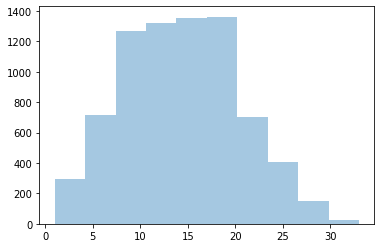

In [11]:
sns.distplot([len(line.split()) for line in xData], kde=False, bins=10)
plt.show()

In [12]:
EMBD_DIM  = 100
MAX_LEN   = 30
MAX_VOCAB = 2000

In [13]:
word2vec = get_word2vec(EMBD_DIM)

In [14]:
tkn = Tokenizer(num_words=MAX_VOCAB)
tkn.fit_on_texts(xData)
seqs = tkn.texts_to_sequences(xData)
seqs = pad_sequences(seqs, maxlen=MAX_LEN)

In [15]:
word2idx          = tkn.word_index
num_words         = min(MAX_VOCAB, len(word2idx)+1)
emmbedding_matrix = np.zeros((num_words, EMBD_DIM))

for word, i in word2idx.items():
    if i < num_words:
        emmbedding_vec = word2vec.get(word)
        if emmbedding_vec is not None:
            emmbedding_matrix[i] = emmbedding_vec

In [16]:
embedding_layer  = Embedding(
    
    input_dim    = num_words,
    output_dim   = EMBD_DIM,
    input_length = MAX_LEN,
    weights      = [emmbedding_matrix],
    trainable    = False

)

In [17]:
ip = Input(shape=(MAX_LEN, ))
x  = embedding_layer(ip)
x  = SpatialDropout1D(.2)(x)
x  = Bidirectional(GRU(units=6, return_sequences=True, dropout=.3, recurrent_dropout=.3, ))(x)
#x  = Dropout(0.3)(x)
x  = GlobalMaxPool1D()(x)
op = Dense(1, activation="sigmoid")(x)

In [18]:
model = Model(ip, op)

model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           200000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 12)            3888      
_________________________________________________________________
global_max_pooling1d (Global (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 203,901
Trainable params: 3,901
Non-trainable params: 200,000
____________________________________________

In [20]:
log = model.fit(
  seqs,
  yData,
  batch_size=256,
  epochs=50,
  validation_split=.3
)

Epoch 1/50
21/21 [==============================] - 1s 41ms/step - loss: 0.6823 - accuracy: 0.5943 - val_loss: 0.6000 - val_accuracy: 0.7417
Epoch 2/50
21/21 [==============================] - 1s 27ms/step - loss: 0.5772 - accuracy: 0.7243 - val_loss: 0.5212 - val_accuracy: 0.7850
Epoch 3/50
21/21 [==============================] - 1s 28ms/step - loss: 0.5209 - accuracy: 0.7506 - val_loss: 0.4636 - val_accuracy: 0.8122
Epoch 4/50
21/21 [==============================] - 1s 27ms/step - loss: 0.4887 - accuracy: 0.7699 - val_loss: 0.4469 - val_accuracy: 0.8047
Epoch 5/50
21/21 [==============================] - 1s 28ms/step - loss: 0.4691 - accuracy: 0.7900 - val_loss: 0.4431 - val_accuracy: 0.8004
Epoch 6/50
21/21 [==============================] - 1s 27ms/step - loss: 0.4598 - accuracy: 0.7919 - val_loss: 0.4519 - val_accuracy: 0.7955
Epoch 7/50
21/21 [==============================] - 1s 27ms/step - loss: 0.4572 - accuracy: 0.7908 - val_loss: 0.4384 - val_accuracy: 0.7938
Epoch 8/50
21

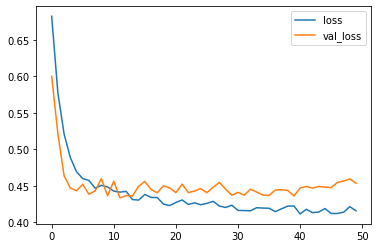

In [21]:
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [22]:
# training model on entire train data for predicting test labels
log = model.fit(
  seqs,
  yData,
  batch_size=256,
  epochs=15,
  validation_split=0
)

Epoch 1/15
30/30 [==============================] - 1s 25ms/step - loss: 0.4296 - accuracy: 0.8112
Epoch 2/15
30/30 [==============================] - 1s 25ms/step - loss: 0.4314 - accuracy: 0.8039
Epoch 3/15
30/30 [==============================] - 1s 24ms/step - loss: 0.4191 - accuracy: 0.8127
Epoch 4/15
30/30 [==============================] - 1s 23ms/step - loss: 0.4293 - accuracy: 0.8043
Epoch 5/15
30/30 [==============================] - 1s 23ms/step - loss: 0.4229 - accuracy: 0.8090
Epoch 6/15
30/30 [==============================] - 1s 27ms/step - loss: 0.4269 - accuracy: 0.8098
Epoch 7/15
30/30 [==============================] - 1s 24ms/step - loss: 0.4246 - accuracy: 0.8089
Epoch 8/15
30/30 [==============================] - 1s 27ms/step - loss: 0.4183 - accuracy: 0.8164
Epoch 9/15
30/30 [==============================] - 1s 24ms/step - loss: 0.4161 - accuracy: 0.8112
Epoch 10/15
30/30 [==============================] - 1s 24ms/step - loss: 0.4160 - accuracy: 0.8099
Epoch 11/

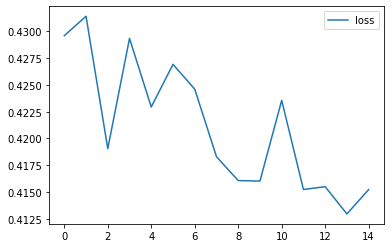

In [23]:
plt.plot(log.history['loss'], label='loss')
plt.legend()
plt.show()

### Test Data

In [24]:
test = pd.read_csv('./dataset/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [25]:
# pre-processing tweets
REMOVE_STOPWORDS = False
xTest = test.text
xTest = xTest.map(lambda tweet:preProc(tweet, REMOVE_STOPWORDS))

In [26]:
test_seq = tkn.texts_to_sequences(xTest)
test_seq = pad_sequences(test_seq, maxlen=MAX_LEN)

In [27]:
yPred = np.array(np.round(model.predict(test_seq)).flatten(), dtype=np.int)

In [29]:
output = pd.DataFrame({"id":test.id, "target":yPred})
output.to_csv('./dataset/gru_results.csv', index=None)